# Importing Libraries

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import re
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, cohen_kappa_score

from sklearn.tree import DecisionTreeClassifier

import nltk
from nltk.corpus import stopwords, cmudict
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

# Describing Data

In [86]:
dataset_train_path = 'Dataset/train.csv'
dataset_test_path = 'Dataset/test.csv'

In [87]:
df_train = pd.read_csv(dataset_train_path)
df_test = pd.read_csv(dataset_test_path)

In [88]:
df_train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [89]:
df_test.head()

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [90]:
print("The shape of the training dataset is: ", df_train.shape)
print("The shape of the testing dataset is: ", df_test.shape)
print("The number of rows in the training dataset is: ", df_train.shape[0])
print("The number of rows in the testing dataset is: ", df_test.shape[0])

The shape of the training dataset is:  (17307, 3)
The shape of the testing dataset is:  (3, 2)
The number of rows in the training dataset is:  17307
The number of rows in the testing dataset is:  3


In [91]:
print("A sample of the full_text column in the training dataset is:\n\n")
print(df_train['full_text'][4])


A sample of the full_text column in the training dataset is:


Dear, State Senator

This is a letter to argue in favor of keeping the Electoral College."There are many reasons to keep the Electoral College" one reason is because it is widely regarded as an anachronism, a dispute over the outcome of an Electoral College vote is possible, but it is less likely than a dispute over the popular vote, and the Electoral College restores some of the weight in the political balance that large states (by population) lose by virue of the mal apportionment of the Senate decreed in the Constitution.

I am in favor of keeping the Electoral College because,it is widely regarded as an anachronism. A non-democratic method of selecting a president that ought to be [overruled] by declaring the canaditdate who receives the most populare votes the winner. The advocates of this position are correct in arguing that the Electoral College method is not democratic in a method sense.It is the electors who elect 

# Data Insights and Visualisation

In [92]:
def count_unique_words(df):
    """
    Counts the number of unique words on the essays in the DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    num_unique_words (int): Number of unique words in the DataFrame.
    """

    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    unique_words = set(words)
    num_unique_words = len(unique_words)
    
    return num_unique_words

In [93]:
def get_average_essay_length(df):
    """
    Calculates the average length of essays in terms of word count.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_length (float): Average length of essays in terms of word count.
    """
    
    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    total_words = len(words)
    num_essays = len(df)
    average_length = total_words / num_essays
    
    return average_length

In [94]:
def calculate_average_word_length(df):
    """
    Calculates the average length of words used in the essays.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_word_length (float): Average length of words in the essays.
    """
    
    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    total_characters = sum(len(word) for word in words)
    total_words = len(words)
    average_word_length = total_characters / total_words
    
    return average_word_length

In [95]:
def calculate_average_words_per_sentence(df):
    """
    Calculates the average number of words per sentence in the dataset.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_words (float): Average number of words per sentence.
    """
   
    sentences = [sent_tokenize(essay) for essay in df['full_text']]
    all_sentences = [sentence for essay_sentences in sentences for sentence in essay_sentences]
    total_words = sum(len(word_tokenize(sentence)) for sentence in all_sentences)
    total_sentences = len(all_sentences)
    average_words = total_words / total_sentences
    
    return average_words

In [96]:
def calculate_average_paragraphs_per_essay(df):
    """
    Calculates the average number of paragraphs per essay in the dataset.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_paragraphs (float): Average number of paragraphs per essay.
    """
    
    df['num_paragraphs'] = df['full_text'].apply(lambda essay: essay.count('\n\n') + 1) 
    average_paragraphs = df['num_paragraphs'].mean()
    
    return average_paragraphs

In [97]:
def calculate_average_sentences_per_paragraph(df):
    """
    Calculates the average number of sentences per paragraph in the dataset.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_sentences (float): Average number of sentences per paragraph.
    """
   
    df['paragraphs'] = df['full_text'].apply(lambda essay: essay.split('\n\n'))
    all_paragraphs = [paragraph for essay_paragraphs in df['paragraphs'] for paragraph in essay_paragraphs]
    num_sentences_per_paragraph = [len(sent_tokenize(paragraph)) for paragraph in all_paragraphs]
    average_sentences = sum(num_sentences_per_paragraph) / len(num_sentences_per_paragraph)
    
    return average_sentences

In [98]:
def calculate_average_words_per_paragraph(df):
    """
    Calculates the average number of words per paragraph in the dataset.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_words (float): Average number of words per paragraph.
    """
    
    df['paragraphs'] = df['full_text'].apply(lambda essay: essay.split('\n\n'))
    all_paragraphs = [paragraph for essay_paragraphs in df['paragraphs'] for paragraph in essay_paragraphs]
    num_words_per_paragraph = [len(word_tokenize(paragraph)) for paragraph in all_paragraphs]
    average_words = sum(num_words_per_paragraph) / len(num_words_per_paragraph)
    
    return average_words

In [99]:
def get_most_common_words(df, stopwords_not_included=True, num_words=10):
    """
    Identifies the most common words used in the essays along with their counts.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    stopwords (bool): Whether to include stopwords or not. If true, stopwords will be removed.
    num_words (int): Number of most common words to return.

    Returns:
    common_words (list of tuples): List of tuples containing the most common words and their counts.
    """
    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()

    if (stopwords_not_included == True):
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word.lower() not in stop_words]
    
    word_counts = Counter(words)
    common_words = word_counts.most_common(num_words)

    df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
    print(df_common_words)
    
    return common_words

In [100]:
def syllable_count_word(word):
    """
    Counts the number of syllables in a word using the CMU Pronouncing Dictionary.

    Parameters:
    word (str): The word for which syllable count needs to be calculated.

    Returns:
    syllable_count (int): The number of syllables in the word.
    """

    d = cmudict.dict()
    
    if word in d:
        syllable_count = max([len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]])
    else:
        syllable_count = 1
    
    return syllable_count

def calculate_fkgl(text):
    """
    Calculates the Flesch-Kincaid Grade Level (FKGL) score for a given text.

    Parameters:
    text (str): The text for which FKGL score needs to be calculated.

    Returns:
    fkgl_score (float): The FKGL score of the text.
    """

    sentences = sent_tokenize(text)
    words = [word.lower() for sentence in sentences for word in word_tokenize(sentence)]
    
    syllable_count = 0
    for word in words:
        syllable_count += syllable_count_word(word)

    average_sentence_length = len(words) / len(sentences)
    average_syllables_per_word = syllable_count / len(words)

    fkgl_score = 0.39 * average_sentence_length + 11.8 * average_syllables_per_word - 15.59
    
    return fkgl_score

In [101]:
def plot_essay_length_distribution(df):
    """
    Plots a histogram showing the distribution of essay lengths in terms of word count.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    """
    
    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    essay_lengths = [len(words) for words in df['full_text'].str.split()]
    
    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(essay_lengths, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Essay Lengths')
    plt.xlabel('Length of Essay (Word Count)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [102]:
def plot_class_distribution(df):
    """
    Plots a bar chart showing the distribution of classes in the dataset.

    Parameters:
    df (DataFrame): DataFrame containing the classes.
    """
    
    df['score'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Distribution of Classes')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

In [103]:
def get_data_insights(df):
    """
    Generates insights from the dataset.

    """
    
    num_unique_words = count_unique_words(df_train)
    average_essay_length = get_average_essay_length(df_train)
    average_word_length = calculate_average_word_length(df_train)
    average_words_per_sentence = calculate_average_words_per_sentence(df_train)
    average_paragraphs = calculate_average_paragraphs_per_essay(df_train)
    average_sentences = calculate_average_sentences_per_paragraph(df_train)
    average_words = calculate_average_words_per_paragraph(df_train)
    print("Number of unique words in the dataset:", num_unique_words)
    print("Average essay length in the dataset:", average_essay_length)
    print("Average word length in the dataset:", average_word_length)
    print("Average number of words per sentence in the dataset:", average_words_per_sentence)
    print("Average number of paragraphs per essay in the dataset:", average_paragraphs)
    print("Average number of sentences per paragraph in the dataset:", average_sentences)
    print("Average number of words per paragraph in the dataset:", average_words)
    print("Most common words in the dataset:")
    get_most_common_words(df_train)
    plot_essay_length_distribution(df_train)
    plot_class_distribution(df_train)

Data Insights for the training dataset:
Number of unique words in the dataset: 129566
Average essay length in the dataset: 368.3482405962905
Average word length in the dataset: 4.557174326035612
Average number of words per sentence in the dataset: 21.421945269988075
Average number of paragraphs per essay in the dataset: 4.965274166522216
Average number of sentences per paragraph in the dataset: 3.9326925314776457
Average number of words per paragraph in the dataset: 82.36881793003933
Most common words in the dataset:
     Word  Count
0   would  43621
1  people  32374
2    cars  32012
3     car  30530
4   could  29338
5    like  22464
6   Venus  21637
7     get  17290
8    also  16948
9   think  15582


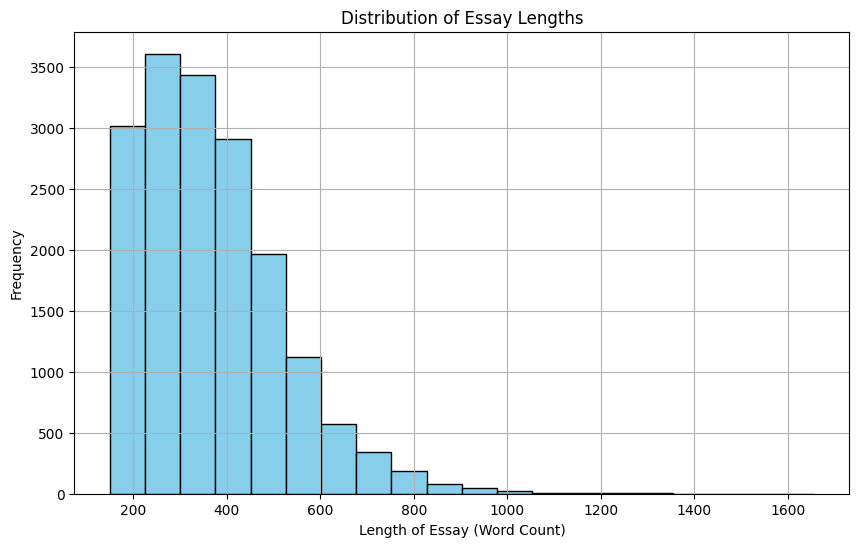

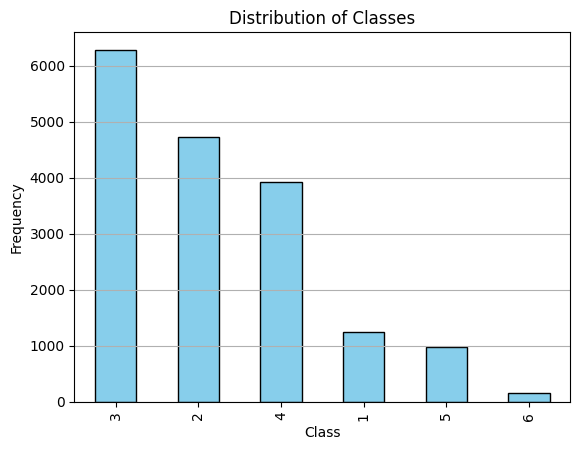

In [104]:
print("Data Insights for the training dataset:")
get_data_insights(df_train)

# Decision Trees

## Data Preprocessing

In [105]:
def remove_urls(text):
    """
    Removes URLs from the text.

    Parameters:
    text (str): The text from which URLs need to be removed.

    Returns:
    text (str): Text with URLs removed.
    """

    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def data_preprocessing(df):
    """
    Preprocesses the data by performing the following steps:
    - Lowercasing
    - Removing URLs
    - Removing punctuation
    - Removing stopwords
    - Lemmatization

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    df (DataFrame): DataFrame with preprocessed essays.
    """

    for index, row in df.iterrows():
        text_value = row['full_text']

        
        text_value = text_value.lower()
        text_value = remove_urls(text_value)
        text_value = re.sub(r'[^\w\s]', '', text_value)

        stop_words = set(stopwords.words('english'))
        text_value = ' '.join([word for word in text_value.split() if word not in stop_words])

        lemmatizer = WordNetLemmatizer()
        text_value = ' '.join([lemmatizer.lemmatize(word) for word in text_value.split()])

        df.at[index, 'full_text_preprocessed'] = text_value

    return df

## TF-IDF Vectoriser

In [106]:
def perform_tfidf(df, column, max_features=1000, min_df=0.0, max_df=1.0, ngram_range=(1, 1), 
                  stop_words=None, tokenizer=None, use_idf=True, smooth_idf=True,
                  sublinear_tf=False, binary=False, norm='l2'):
    """
    Performs TF-IDF vectorization on the essays in the DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    column (str): Name of the column containing the essays.
    max_features (int or None): Maximum number of features (unique words) to consider.
    min_df (float or int): Minimum document frequency for words to be included.
    max_df (float or int): Maximum document frequency for words to be included.
    ngram_range (tuple): Range of n-grams to consider.
    stop_words (str, list, or None): Stop words to be ignored during tokenization.
    tokenizer (callable or None): Custom tokenizer function.
    use_idf (bool): Whether to use inverse document frequency (IDF) in TF-IDF calculation.
    smooth_idf (bool): Whether to add a constant term to the IDF calculation.
    sublinear_tf (bool): Whether to apply logarithmic scaling to term frequency (TF) values.
    binary (bool): Whether to use binary frequency counts instead of raw term frequencies.
    norm (str or None): Normalization method for the TF-IDF matrix.

    Returns:
    tfidf_matrix (array): TF-IDF matrix representing the essays.
    feature_names (list): List of feature names (words) corresponding to the columns of the TF-IDF matrix.
    """
    essays = df[column].tolist()

    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df, max_df=max_df,
                                       ngram_range=ngram_range, stop_words=stop_words,
                                       tokenizer=tokenizer, use_idf=use_idf,
                                       smooth_idf=smooth_idf, sublinear_tf=sublinear_tf,
                                       binary=binary, norm=norm)
    
    tfidf_matrix = tfidf_vectorizer.fit_transform(essays)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    return tfidf_matrix, feature_names

## Decision Tree Model

In [107]:
def train_decision_tree_classifier(X_train, y_train, criterion='gini', splitter='best', max_depth=None,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                   max_features=None, random_state=None, max_leaf_nodes=None,
                                   min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0):
    """
    Trains a Decision Tree Classifier with specified parameters.

    Parameters:
    X_train (array-like): Feature matrix for training.
    y_train (array-like): Target variable for training.
    criterion (str): The function to measure the quality of a split.
    splitter (str): The strategy used to choose the split at each node.
    max_depth (int): The maximum depth of the tree.
    min_samples_split (int or float): The minimum number of samples required to split an internal node.
    min_samples_leaf (int or float): The minimum number of samples required to be at a leaf node.
    min_weight_fraction_leaf (float): The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
    max_features (int, float or {'auto', 'sqrt', 'log2'}): The number of features to consider when looking for the best split.
    random_state (int or None): Seed of the random number generator for reproducibility.
    max_leaf_nodes (int or None): Grow a tree with max_leaf_nodes in best-first fashion.
    min_impurity_decrease (float): A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
    class_weight (dict, list of dict or 'balanced', default=None): Weights associated with classes in the form {class_label: weight}.
    ccp_alpha (non-negative float, default=0.0): Complexity parameter used for Minimal Cost-Complexity Pruning.
    monotonic_cst (array-like of int of shape (n_features), default=None): Constraints on the signs of the coefficients for each feature.
    
    Returns:
    clf (DecisionTreeClassifier): Trained Decision Tree Classifier.
    """
    clf = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth,
                                 min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                 min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features,
                                 random_state=random_state, max_leaf_nodes=max_leaf_nodes,
                                 min_impurity_decrease=min_impurity_decrease, class_weight=class_weight,
                                 ccp_alpha=ccp_alpha)
    

    clf.fit(X_train, y_train)
    
    return clf

## Testing the Model

In [108]:
def compute_cohen_kappa_score(eval_pred):
    """
    Computes the Cohen's Kappa score for the predictions.

    Parameters:
    eval_pred (tuple): Tuple containing the predictions and labels.

    Returns:
    results (dict): Dictionary containing the Cohen's Kappa score.
    """
    
    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.clip(0, 5).round(0), weights='quadratic')
    results = {'qwk': qwk}
    return results

In [112]:
def evaluate_decision_trees_model(df, train_split=0.7, val_split=0.1, test_split=0.2, kFold=5):
    """
    Splits the data into training, validation, and test sets, performs k-fold cross-validation on the training set,
    and evaluates the final model on the test set using Decision Tree Classifier and TF-IDF vectorization.

    Parameters:
    df (DataFrame): DataFrame containing features (X) and target variable (y).
    train_split (float): Proportion of data to use for training.
    val_split (float): Proportion of data to use for validation.
    test_split (float): Proportion of data to use for testing.
    kFold (int): Number of folds for cross-validation.

    Returns:
    test_accuracy (float): Accuracy of the model on the test set.
    """
    X = df['full_text_preprocessed'] 
    y = df['score']  

    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_split, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=val_split / (train_split + val_split), random_state=42)

    kf = KFold(n_splits=kFold, shuffle=True, random_state=42)
    train_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        X_train_fold_df = pd.DataFrame(X_train_fold, columns=['full_text_preprocessed'])
        X_val_fold_df = pd.DataFrame(X_val_fold, columns=['full_text_preprocessed'])
        
        tfidf_matrix_train, feature_names = perform_tfidf(X_train_fold_df, 'full_text_preprocessed')
        tfidf_matrix_val, _ = perform_tfidf(X_val_fold_df, 'full_text_preprocessed')
        
        model = train_decision_tree_classifier(tfidf_matrix_train, y_train_fold)
        
        val_preds = model.predict(tfidf_matrix_val)
        val_accuracy = accuracy_score(y_val_fold, val_preds)
        train_scores.append(val_accuracy)

    print("Cross-Validation Scores:", train_scores)

    X_train_full_df = pd.DataFrame(X_train_full, columns=['full_text_preprocessed'])
    X_test_df = pd.DataFrame(X_test, columns=['full_text_preprocessed'])
    
    tfidf_matrix_train_full, _ = perform_tfidf(X_train_full_df, 'full_text_preprocessed')
    tfidf_matrix_test, _ = perform_tfidf(X_test_df, 'full_text_preprocessed')
    
    final_model = train_decision_tree_classifier(tfidf_matrix_train_full, y_train_full)
    
    test_preds = final_model.predict(tfidf_matrix_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    
    print("Classification Report:")
    print(classification_report(y_test, test_preds, zero_division=1))  
    print("Accuracy:", test_accuracy) 

    eval_pred = (test_preds, y_test)
    eval_results = compute_cohen_kappa_score(eval_pred)
    print("QWK Score:", eval_results['qwk'])

    print("True Labels:", y_test.values)
    print("Predicted Labels:", test_preds)

    cm = confusion_matrix(y_test, test_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(test_preds), yticklabels=np.unique(test_preds))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return test_accuracy


In [110]:
df_train = data_preprocessing(df_train)

Cross-Validation Scores: [0.25257944696657036, 0.31778786628146927, 0.30169211721007017, 0.2624845233182006, 0.29232039636663915]
Classification Report:
              precision    recall  f1-score   support

           1       0.09      0.12      0.10       260
           2       0.29      0.44      0.35       965
           3       0.36      0.33      0.35      1265
           4       0.28      0.19      0.22       750
           5       0.08      0.01      0.02       183
           6       0.12      0.03      0.04        39

    accuracy                           0.29      3462
   macro avg       0.21      0.19      0.18      3462
weighted avg       0.29      0.29      0.28      3462

Accuracy: 0.2949162333911034
QWK Score: 0.13958179137588567
True Labels: [3 3 3 ... 2 2 2]
Predicted Labels: [2 2 2 ... 3 3 4]


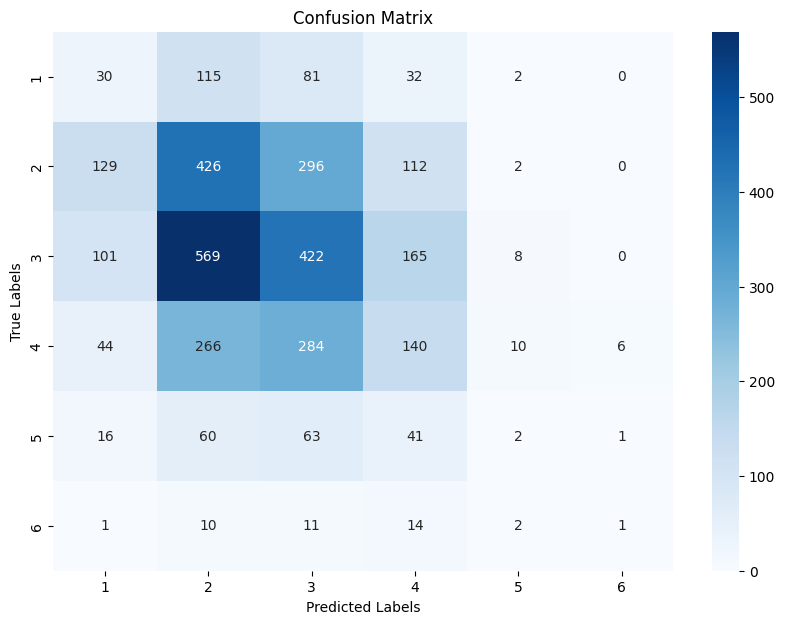

In [113]:
accuracy_score_final = evaluate_decision_trees_model(df_train)